# Getting started with Echopype

In this notebook, we will focus on the steps to convert instrument-generated raw data files, compute the volume backscattering strength (Sv) based on calibration and environmental parameters already stored in the file, and plot an echogram.
We will use a `.raw` file generated by a Simrad EK80 echosounder as an example.
Please see the Echopype [documentation](https://echopype.readthedocs.io/en/stable/convert.html#supported-raw-file-types) for usage with other supported formats.

In [1]:
import warnings

import echopype as ep  # we recommend using "ep"
import xarray as xr
import hvplot.xarray  # for interactive plots

import matplotlib.pyplot as plt

Here we will use an example file collected as part of the [Hake survey](https://www.fisheries.noaa.gov/west-coast/science-data/joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey) run by the NOAA Northwest Fisheries Science Center, stored in an [open AWS data register from NOAA NCEI](https://registry.opendata.aws/ncei-wcsd-archive/).

Here we directly access and convert data from an S3 bucket without having to download them first. Echopype supports accessing data from multiple sources, such as a local filesystem (e.g., hard disk), a cloud object store (e.g., AWS S3), an http server, etc.

## Convert raw data

In [2]:
raw_path = "s3://noaa-wcsd-pds/data/raw/Bell_M._Shimada/SH2306/EK80/Hake-D20230811-T165727.raw"
ed = ep.open_raw(
    raw_path,
    sonar_model="EK80",
    storage_options={"anon": True},  # open bucket, otherwise need credential
)

In [3]:
type(ed)

echopype.echodata.echodata.EchoData

Let's take a look at what's in `ed`, and `EchoData` object.

An `EchoData` object is a representation of an echopype-adapted version of the SONAR-netCDF4 version 1 convention. It shows the tree-like group structure in the netCDF data model. We aim for the conversion from raw data to the `EchoData` object as lossless as possible.

To see what we changed from the convention and why, please see the **Data standardization** section of the [Echopype paper](https://doi.org/10.1093/icesjms/fsae133).

In [4]:
ed

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

There are a few things to note in this example:
- All backscatter data are in the `Sonar/Beam_group1` group
- The backscatter data and many other variables are aligned in 3 major dimensions: `channel`, `ping_time`, `range_sample`
    - `channel` includes all the transducer channel, and for EK80 files these are the channel IDs configured in the EK80 system during data collection.
    - We chose to use `channel` instead of frequency to align the data, because some setups use multiple transducers transmitting at the same frequency but pointing in different directions. Additionally, "frequency" can be a misnomer broadband transmissions
    - We store the "frequency" of the channels in the variable `frequency_nominal` for easy access
    - `range_sample` are 0-based sample count of the received echoes
- Useful overview type of information are stored in the `Top-level` group, which is the "root" of the netCDF file
- Raw NMEA datagrams are found in the `Platform/NMEA` group
- Raw CONFIG datagram, which is an XML string, is save in the variable `content` in the `Vendor_specific` group

In addition, since `ed` is just converted and has not been saved, everything is stored **in-memory**, as indicated in the first line printed out below.

:::{note}
Echopype does not yet support ping-sequence files! We expect that to be part of an upcoming releases.
:::

### Saving the `EchoData` object

Echopype supports saving the `EchoData` object into a netCDF file (`.nc`) or a zarr store (`.zarr`). The groups and the representation stay the same, just the format specification is different. NetCDF files are single files that are easy to handle on a conventional filesystem. Zarr stores are optimized for cloud storage, but can be messy to access on a local filesystem as it would show up as many many folder. Both formats and the tools to access them continue to develop, and in particular there are recent new packages that allow representing multiple netCDF files as a virtual zarr store, so things are becoming more convenient and powerful on the user side!

In [5]:
# Save to a zarr file
export_path = "./exports/getting_started/ed_example.zarr"

ed.to_zarr(export_path, overwrite="w")

### Lazy-load an `EchoData` object

We can load the saved zarr back using the `open_converted` function.

By using `chunks={}`, we "lazy-load" all the data in this zarr file into a new `EchoData` object, `ed_new`, which can be seen as a representation or a handle of the data stored on disk.

This capability is very important for distributed computing and is key to out-of-core computation, because different "workers" can directly access different parts of the same file on disk, and don't have load the entire dataset into memory. This file is pretty small, but in the `OOI_eclipse.ipynb` notebook, you can see an example in which the zarr file is approximately 8 GB and its computation would generally overwhelm a regular laptop without distributed computing capability.

In [6]:
ed_new = ep.open_converted(export_path, chunks={})

We can find out if a variable is lazy-loaded or completely loaded into memory by looking at the representation:

In [7]:
# In-memory: see all the values
ed["Sonar/Beam_group1"]["backscatter_r"]

<xarray.DataArray 'backscatter_r' (channel: 5, ping_time: 213,
                                   range_sample: 36198)> Size: 154MB
array([[[  10.383183  ,   13.875601  ,   16.015736  , ...,
                   nan,           nan,           nan],
        [  10.430219  ,   13.910878  ,   16.051014  , ...,
                   nan,           nan,           nan],
        [  10.383183  ,   13.875601  ,   16.015736  , ...,
                   nan,           nan,           nan],
        ...,
        [  10.465496  ,   13.969673  ,   16.121567  , ...,
                   nan,           nan,           nan],
        [  10.465496  ,   13.969673  ,   16.121567  , ...,
                   nan,           nan,           nan],
        [  10.430219  ,   13.899119  ,   16.051014  , ...,
                   nan,           nan,           nan]],

       [[ -11.782502  ,   -5.7031074 ,   -0.50563633, ...,
         -125.868164  , -126.09158   , -126.29149   ],
        [ -11.711948  ,   -5.6443124 ,   -0.47035936, ...,
         -133.06467   , -130.23074   , -127.82016   ],
        [ -11.770743  ,   -5.6795893 ,   -0.49387732, ...,
         -133.14697   , -132.48848   , -131.8182    ],
...
        [   3.5394542 ,   10.41846   ,   15.780557  , ...,
                   nan,           nan,           nan],
        [   3.4689002 ,   10.383183  ,   15.757039  , ...,
                   nan,           nan,           nan],
        [   3.4924183 ,   10.383183  ,   15.757039  , ...,
                   nan,           nan,           nan]],

       [[   6.067636  ,    8.866274  ,   10.747711  , ...,
                   nan,           nan,           nan],
        [   6.079395  ,    8.842756  ,   10.747711  , ...,
                   nan,           nan,           nan],
        [   6.2087436 ,    9.019141  ,   10.912337  , ...,
                   nan,           nan,           nan],
        ...,
        [   6.3028154 ,    9.077936  ,   10.959373  , ...,
                   nan,           nan,           nan],
        [   6.2087436 ,    9.0309    ,   10.935855  , ...,
                   nan,           nan,           nan],
        [   6.3028154 ,    9.077936  ,   10.971132  , ...,
                   nan,           nan,           nan]]], dtype=float32)
Coordinates:
  * channel       (channel) <U25 500B 'WBT 400140-15 ES120-7C_ES' ... 'WBT 40...
  * ping_time     (ping_time) datetime64[ns] 2kB 2023-08-11T16:57:27.277163 ....
  * range_sample  (range_sample) int64 290kB 0 1 2 3 ... 36194 36195 36196 36197
Attributes:
    long_name:  Raw backscatter measurements (real part)
    units:      dB

In [8]:
# Lazy-loaded: see the entire array size and the chunk size
ed_new["Sonar/Beam_group1"]["backscatter_r"]

<xarray.DataArray 'backscatter_r' (channel: 5, ping_time: 213,
                                   range_sample: 36198)> Size: 154MB
dask.array<open_dataset-backscatter_r, shape=(5, 213, 36198), dtype=float32, chunksize=(5, 213, 23474), chunktype=numpy.ndarray>
Coordinates:
  * channel       (channel) <U25 500B 'WBT 400140-15 ES120-7C_ES' ... 'WBT 40...
  * ping_time     (ping_time) datetime64[ns] 2kB 2023-08-11T16:57:27.277163 ....
  * range_sample  (range_sample) int64 290kB 0 1 2 3 ... 36194 36195 36196 36197
Attributes:
    long_name:  Raw backscatter measurements (real part)
    units:      dB

We just need 1 `EchoData` for processing below, so we can delete `ed_new`.

In [9]:
del ed_new

### Accessing `EchoData` groups directly via xarray

Note that the zarr or netCDF files on disk are actually standard files, and can be access using regular xarray functions. For example, we an access the GPS data stored in the `Platform` group directly using `xarray.open_dataset`:

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=RuntimeWarning)  # ignore warning to focus on tutorial message

    ds_platform = xr.open_dataset(f"{export_path}/Platform", engine="zarr")

In [11]:
ds_platform

<xarray.Dataset> Size: 127kB
Dimensions:                      (channel: 5, time2: 1837, time1: 1451, time3: 1)
Coordinates:
  * channel                      (channel) <U25 500B 'WBT 400140-15 ES120-7C_...
  * time1                        (time1) datetime64[ns] 12kB 2023-08-11T16:57...
  * time2                        (time2) datetime64[ns] 15kB 2023-08-11T16:57...
  * time3                        (time3) datetime64[ns] 8B 2023-08-11T16:57:2...
Data variables: (12/26)
    MRU_offset_x                 float64 8B ...
    MRU_offset_y                 float64 8B ...
    MRU_offset_z                 float64 8B ...
    MRU_rotation_x               float64 8B ...
    MRU_rotation_y               float64 8B ...
    MRU_rotation_z               float64 8B ...
    ...                           ...
    transducer_offset_x          (channel) float64 40B ...
    transducer_offset_y          (channel) float64 40B ...
    transducer_offset_z          (channel) float64 40B ...
    vertical_offset              (time2) float64 15kB ...
    water_level                  float64 8B ...
    water_level_draft_is_manual  int64 8B ...
Attributes:
    platform_code_ICES:  
    platform_name:       
    platform_type:

## Compute Sv

We can then proceed to compute Sv from the raw data. Here, we will use the calibration and environmental parameters already stored in the original instrument-generated `.raw` file to do it. Echopype also supports updating these parameters as part of the function call, or use an Echoview `.ECS` file (though note that this functionality is in beta and may not cover all the equivalent vocabulary recognized by Echoview).

`compute_Sv` requires two arguments: `waveform_mode` and `encode_mode`, because EK80 files can contain data from a variety of sampling configurations, including:
- narrowband data stored in power-angle format (`waveform_mode="CW", encode_mode="power"`)
- narrowband data stored in complex format (`waveform_mode="CW", encode_mode="complex"`)
- broadband data stored in complex format (`waveform_mode="FM", encode_mode="complex"`)

For AZFP echosounder, the arguments will always be `waveform_mode="CW", encode_mode="power"` since the instrument does not yet support broadband transmissions.

If these arguments are not provided, `compute_Sv` will error out for EK80 data:

In [12]:
# Try to compute Sv without correct arguments will error out
ds_Sv = ep.calibrate.compute_Sv(ed)

ValueError: waveform_mode and encode_mode must be specified for EK80 calibration

With the correct argument combination is used, we can proceed to take a look at the Sv output:

In [13]:
# Use the correct combination
ds_Sv = ep.calibrate.compute_Sv(ed, waveform_mode="CW", encode_mode="power")

### Content of the Sv dataset

In [14]:
ds_Sv

<xarray.Dataset> Size: 617MB
Dimensions:                        (channel: 5, ping_time: 213,
                                    range_sample: 36198, filenames: 1)
Coordinates:
  * channel                        (channel) <U25 500B 'WBT 400140-15 ES120-7...
  * ping_time                      (ping_time) datetime64[ns] 2kB 2023-08-11T...
  * range_sample                   (range_sample) int64 290kB 0 1 ... 36197
  * filenames                      (filenames) int64 8B 0
Data variables: (12/24)
    Sv                             (channel, ping_time, range_sample) float64 308MB ...
    echo_range                     (channel, ping_time, range_sample) float64 308MB ...
    frequency_nominal              (channel) float64 40B 1.2e+05 ... 2e+05
    sound_speed                    float64 8B 1.48e+03
    sound_absorption               (channel) float64 40B 0.03281 ... 0.0463
    temperature                    float64 8B 6.9
    ...                             ...
    beamwidth_athwartship          (channel) float64 40B 6.74 10.6 ... 6.81 6.07
    impedance_transducer           (channel) float64 40B 75.0 75.0 ... 75.0 75.0
    impedance_transceiver          (channel) int64 40B 5400 5400 5400 5400 5400
    receiver_sampling_frequency    (channel) float64 40B 1.5e+06 ... 1.5e+06
    source_filenames               (filenames) <U82 328B 's3://noaa-wcsd-pds/...
    water_level                    float64 8B 0.0
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.10.1
    processing_time:              2025-04-06T19:40:42Z
    processing_function:          calibrate.compute_Sv

`ds_Sv` is a standard xarray `Dataset` with multiple data variable, each an xarray `DataArray`.

In addition to the `Sv` variable, there are many other variables in this dataset, including:
- all calibration and environmental parameters used to compute the Sv values, to ensure traceability and reproducibility
- the `echo_range` variable that contains the range of each echo sample from the transducer

`echo_range` has the same dimension as the `Sv` variable, because the sampling rate of the echo time series (step size along range) and sound speed may vary across pings depending on the echosounder configuration and the environment.

It is also often useful to have the Sv dataset aligned with the `frequency_nominal` instead of `channel`:

Let's take a quick look at what the Sv data looks like:

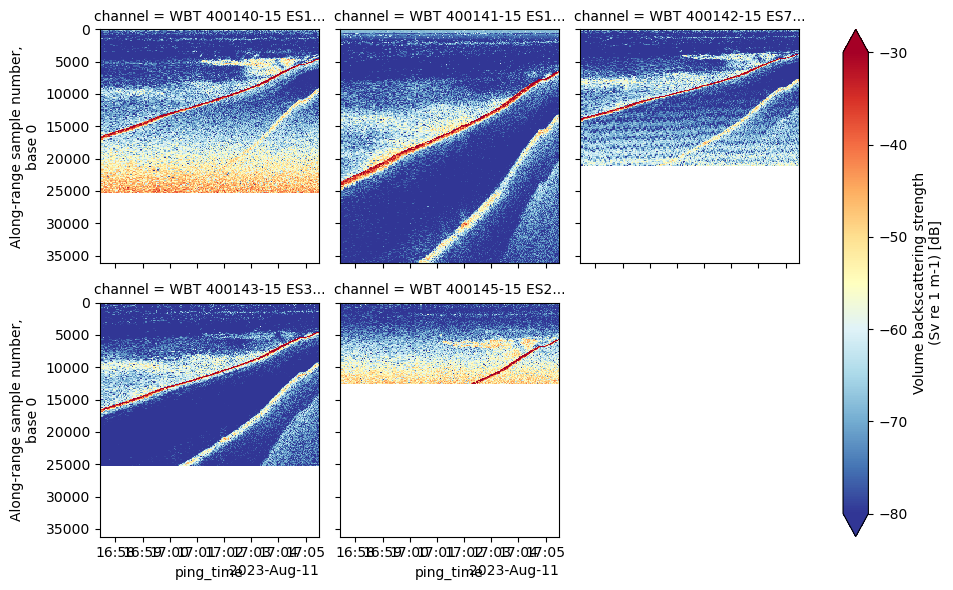

In [15]:
ds_Sv["Sv"].plot(
    x="ping_time", 
    row="channel", col_wrap=3,
    vmin=-80, vmax=-30,
    cmap="RdYlBu_r", yincrease=False
)

We can see that there are lots of `NaN` (empty) entries in this dataset, and the number of along-range samples are different for different channels. This is because the echosounder was configured to collect data up to different range, and the sample interval (step size) can also be different for different channels.

:::{tip}
In Echopype, we chose to pad `NaN` for shorter pings and channels, so that the data are **gridded** at the raw data and all subsequent stages. This makes it much easier to slice different parts of data out, and helps with computing efficiency.

This choice is one of the key differences between Echopype-adapted data format and SONAR-netCDF4 definitions. See the Echopype [documentation](https://echopype.readthedocs.io/en/stable/data-format-sonarnetcdf4.html#nan-padding) for more information.
:::

### Correct reversed ping time

For some reason, the EK echosounders sometimes generate ping times that are reversed in time, by a tiny amount (<1 msec scale). Reversed coordinate values are problematic for xarray and many operations, and we can correct them by using functions in the `qc` subpackage:

In [16]:
# Correct reveresed ping time
from echopype.qc import exist_reversed_time, coerce_increasing_time

if exist_reversed_time(ds_Sv, "ping_time"):
    # Coerce increasing time
    coerce_increasing_time(ds_Sv)

## Add additional information to the Sv dataset

The Sv dataset generated by `compute_Sv` only contains backscatter data, but we often need additional information, such as the latitude/longitutude location of the platform, or the split-beam angle inferred from the echo time series. We can add these into the dataset by calling functions from the `consolidate` subpackage. We can also compute the depth of each echo sample if the platform depth is known.

For data saved in complex format, the split-beam angles are calculated from the samplesy. For data saved in power-angle format, the split-beam angle is directly extracted from the `EchoData` object since it's already part of the raw file.

:::{note}
Echopype does not yet support heave compensation.
:::

Adding depth and split-beam angle would run through fine:

In [17]:
# Add depth
# depth_offset=9.8 because transducer was on a lowered centerboard at 9.8 m deep
ds_Sv = ep.consolidate.add_depth(ds_Sv, ed, depth_offset=9.8)

In [18]:
# Add split-beam angle
# also need waveform_mode and encode_mode to determine how to extract or compute split-beam angles
ds_Sv = ep.consolidate.add_splitbeam_angle(ds_Sv, ed, waveform_mode="CW", encode_mode="power", to_disk=False)

But trying to add the GPS location would error out on first try, because there's are duplicated values in `time1`:

In [19]:
# Add geographical location
ds_Sv = ep.consolidate.add_location(ds_Sv, ed)

ValueError: The ``echodata["Platform"]["time1"]`` array contains duplicate values. Downstream interpolation on the position variables requires unique time values.

This call errored out, because there's are duplicated values in `time1`. We decided to not handle this case automatically, because it is hard to infer why such data came about in the first place. We feel it is safer for users to make their own decision and clean up their GPS data before proceeding.

Below we do some cleaning, first by subsetting only the "GGA" NMEA sentences that have high resolution GPS data, and removing the first element that duplicates with the second element in `time1`.

In [20]:
# Clean up GPS data
ed["Platform"] = ed["Platform"].where((ed["Platform"]["sentence_type"]=="GGA"), drop=True)
ed["Platform"] = ed["Platform"].isel(time1=slice(1, None))

In [21]:
# Add geographical location
ds_Sv = ep.consolidate.add_location(ds_Sv, ed)

After these operations, we now have an Sv dataset that contains pretty useful data that we can use for downstream analysis.

## Compute MVBS

We can bring them onto the same grid by computing the mean volume backscattering strength (MVBS):

In [27]:
# Compute MVBS
ds_MVBS = ep.commongrid.compute_MVBS(
    ds_Sv,
    range_var="depth",
    range_bin="1m",
    ping_time_bin="5s",
    range_var_max="500m",  # max range to bin
)

In [28]:
# It's often useful to display frequency_nominal rather than channel
ds_MVBS = ds_MVBS.swap_dims({"channel": "frequency_nominal"})

Now, all channels are bin-averaged on the same grid:

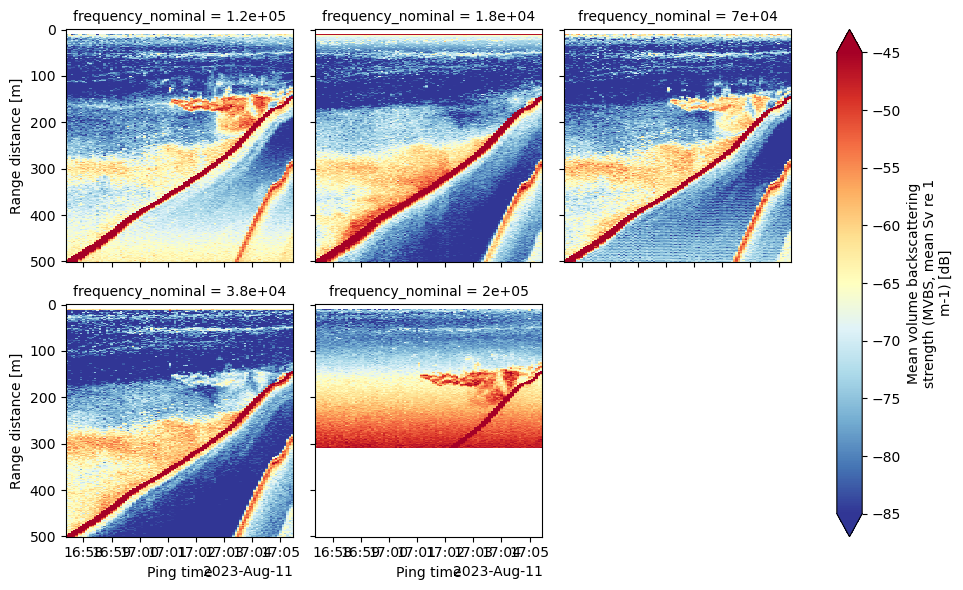

In [24]:
ds_MVBS["Sv"].plot(
    x="ping_time",
    row="frequency_nominal", col_wrap=3,
    cmap='RdYlBu_r', yincrease=False,
    vmin=-85, vmax=-45
)

And we can use `hvPlot` to quickly plot an interactive figure:

In [25]:
ds_MVBS["Sv"].hvplot.quadmesh(
    x="ping_time", clim=(-80, -30), figsize=(6, 6), cmap="RdYlBu_r", rasterize=True,
    groupby="frequency_nominal"
).opts(invert_yaxis=True, height=400)

:DynamicMap   [frequency_nominal]
   :Image   [ping_time,depth]   (Mean volume backscattering strength (MVBS, mean Sv re 1 m-1))